# Stock Price Predictor Project

> ### Importing the Necessary Libraries and Modules.
> * Yfinance for accessing stock data, pandas to handle series and data analysis, Sci-kit learn for ML, and Numpy to handle arrays.
> * I will be using [RandomForestClassifier](https://www.datacamp.com/tutorial/random-forests-classifier-python) for data handling.
> * precision_score - correct possitive predictions, recall_score - identified posititve cases, accuracy_score - total correct predictions.

In [38]:
import yfinance as yf
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt

> ### 'load_data' Variable Retrieving the Data
> * Input parameters are the ticker name and starting date for the data default being 2010-01-01.
> * The code makes a deep copy of the data from the starting date
> * The code drops the unnecassary columns

In [8]:
def load_data(ticker, start_date="2010-01-01"):
    data = yf.Ticker(ticker).history(period="max")
    data = data.loc[start_date:].copy()
    data.drop(columns=["Dividends", "Stock Splits"], inplace=True)
    display(data)
    return data

> * Lets see what we got)

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04 00:00:00-05:00,6.429938,6.462173,6.398305,6.447411,493729600
2010-01-05 00:00:00-05:00,6.465186,6.495011,6.424515,6.458558,601904800
2010-01-06 00:00:00-05:00,6.458560,6.484168,6.349200,6.355828,552160000
2010-01-07 00:00:00-05:00,6.379324,6.386856,6.297982,6.344076,477131200
2010-01-08 00:00:00-05:00,6.335643,6.386859,6.298287,6.386256,447610800
...,...,...,...,...,...
2024-11-18 00:00:00-05:00,225.250000,229.740005,225.169998,228.020004,44686000
2024-11-19 00:00:00-05:00,226.979996,230.160004,226.660004,228.279999,36211800
2024-11-20 00:00:00-05:00,228.059998,229.929993,225.889999,229.000000,35169600


<Axes: xlabel='Date'>

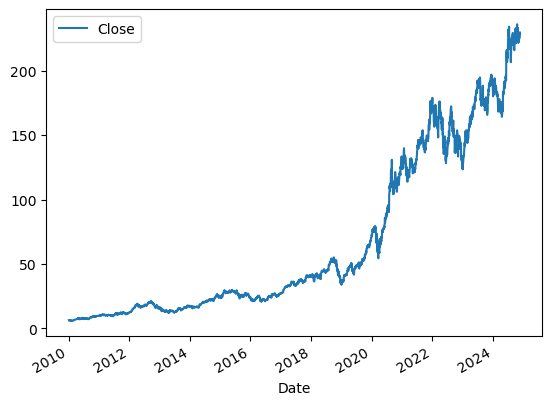

In [10]:
aapl_data = load_data("AAPL")
aapl_data.plot.line(y="Close", use_index=True) 

> ### Adding New Features
> * Drop the unnecesarry columns.
> * Create a new column "Tomorrow" by shifting "Close" one row up.
> * Create a new column "Target" to see if Tomorrow>Close in binary.
> * State predictors that will be used in the ML model.
> * Calculate the moving average over a horizon.
> * Add new columns: close/rolling_avg and number of positive (1) days over a horizon using f-strings.
> * Remove rows w/ any missing values
> * Make the DataFrame displayable
> * Update the DataFrame and add new features to the predictors list.

In [12]:
def create_features(data, horizons):
    data.drop(columns=["Dividends", "Stock Splits"], inplace=True, errors="ignore")
    data["Tomorrow"] = data["Close"].shift(-1)
    data["Target"] = (data["Tomorrow"] > data["Close"]).astype(int)
    predictors = ["Open", "High", "Low", "Close", "Volume"]
    for horizon in horizons:
        rolling_avg = data["Close"].rolling(horizon).mean()
        data[f"Close_Ratio_{horizon}"] = data["Close"] / rolling_avg
        data[f"Trend_{horizon}"] = data["Target"].shift(1).rolling(horizon).sum()
    data.dropna(inplace=True)
    display(data.head())
    return data, predictors + [f"Close_Ratio_{h}" for h in horizons] + [f"Trend_{h}" for h in horizons]

In [13]:
aapl_data, predictors = create_features(aapl_data, [5, 10, 20])

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_5,Trend_5,Close_Ratio_10,Trend_10,Close_Ratio_20,Trend_20
Date,,,,,,,,,,,,,
2010-02-02 00:00:00-05:00,5.902120,5.914471,5.825899,5.900613,698342400,6.002140,1,0.989372,3.0,0.971345,5.0,0.950046,9.0
2010-02-03 00:00:00-05:00,5.879826,6.031363,5.857231,6.002140,615328000,5.785832,0,1.015267,3.0,0.994221,6.0,0.969956,9.0
2010-02-04 00:00:00-05:00,5.926824,5.976232,5.771371,5.785832,757652000,5.888562,1,0.985954,3.0,0.966115,6.0,0.939327,9.0
2010-02-05 00:00:00-05:00,5.803304,5.904831,5.749678,5.888562,850306800,5.848192,0,0.999969,4.0,0.984402,7.0,0.959553,10.0
2010-02-08 00:00:00-05:00,5.895491,5.961468,5.844576,5.848192,478270800,5.910556,1,0.993734,3.0,0.982080,6.0,0.957171,9.0


> ### Defining of Training of the Model
> * A threshold of 0.6 to increase the precision score.
> * Train using the "predictors", with "Target" being the values to predict.
> * Compute probabilities only extracting positive predictions (1).
> * Convert probabilities into binary predictions
> * Return the predictions as a indexed panda series.

In [15]:
def predict(train, test, predictors, model, threshold=0.6):
    model.fit(train[predictors], train["Target"])
    probabilities = model.predict_proba(test[predictors])[:, 1]
    predictions = (probabilities >= threshold).astype(int)
    return pd.Series(predictions, index=test.index, name="Predictions")

> ### Defining of Backtesting
> * The model will learn on every 2500 rows and test subsequent 500 rows after every itteration. <br> Use a threshold of 0.6 to convert probabilities into binary predictions.
> * Create a list to store actual targets and predictions
> * Create a loop to itterate through the entire dataset logically arranging train and teat variables
> * Return a pandas series containing the predicitons for the test set
> * Combine "Target" and predictions into one DataFrame containing 2 columns
> * Add individual DataFrames "Combine" to the all_predictions list.
> * Combine DataFrames from all itterations into all_predictions DataFrame

In [17]:
def backtest(data, model, predictors, start=500, step=50, threshold=0.6):
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[:i].copy()
        test = data.iloc[i:i + step].copy()
        predictions = predict(train, test, predictors, model, threshold)
        combined = pd.concat([test["Target"], predictions], axis=1)
        all_predictions.append(combined)
    return pd.concat(all_predictions)

> ### Model Training
> * Load historical data from Apple using a pre_defined function "load_data".
> * Apply a pre-definied function "crate_features" and state the desired horizons.
> * Initialize RandomForestClasifier, random_state=1 for results consistency.
> * Perform backtesting using a pre-defined funtion "becktest".

In [19]:
data = load_data("AAPL")
data, predictors = create_features(data, horizons=[2, 5, 60, 250, 1000])
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
predictions = backtest(data, model, predictors)

,Open,High,Low,Close,Volume
Date,,,,,
2010-01-04 00:00:00-05:00,6.429939,6.462174,6.398306,6.447412,493729600
2010-01-05 00:00:00-05:00,6.465187,6.495012,6.424515,6.458559,601904800
2010-01-06 00:00:00-05:00,6.458560,6.484168,6.349200,6.355828,552160000
2010-01-07 00:00:00-05:00,6.379325,6.386857,6.297982,6.344076,477131200
2010-01-08 00:00:00-05:00,6.335642,6.386858,6.298286,6.386255,447610800
...,...,...,...,...,...
2024-11-18 00:00:00-05:00,225.250000,229.740005,225.169998,228.020004,44686000
2024-11-19 00:00:00-05:00,226.979996,230.160004,226.660004,228.279999,36211800
2024-11-20 00:00:00-05:00,228.059998,229.929993,225.889999,229.000000,35169600


,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2013-12-23 00:00:00-05:00,17.697613,17.782362,17.534347,17.762733,501306400,17.687332,0,1.018827,2.0,1.029292,2.0,1.087801,33.0,1.223619,126.0,1.402980,528.0
2013-12-24 00:00:00-05:00,17.756501,17.818506,17.636232,17.687332,167554800,17.569864,0,0.997873,1.0,1.020252,2.0,1.079966,33.0,1.217743,125.0,1.395787,527.0
2013-12-26 00:00:00-05:00,17.700727,17.744348,17.553662,17.569864,204008000,17.451159,0,0.996668,0.0,1.008715,2.0,1.070120,32.0,1.208962,125.0,1.385291,527.0
2013-12-27 00:00:00-05:00,17.567378,17.585760,17.432776,17.451159,225884400,17.277607,0,0.996610,0.0,0.996329,2.0,1.060430,31.0,1.200373,124.0,1.374728,527.0
2013-12-30 00:00:00-05:00,17.369212,17.451156,17.209060,17.277607,253629600,17.480133,1,0.995003,0.0,0.984494,1.0,1.047440,31.0,1.188242,123.0,1.359889,526.0


> ### Retrieving Results
> * Assigning a pre-defined function "precision_score" to "precision" (how many of predicted "1s" were correct).
> * Assigning a pre-defined function "recall_score" to "recall" (how many actual "1s" were correctly predicted).
> * Assigning a pre-defined function "accuracy_score" to "accuracy" (how often model's predictions were correct).
> * print the results via an f-string.

In [21]:
precision = precision_score(predictions["Target"], predictions["Predictions"])
recall = recall_score(predictions["Target"], predictions["Predictions"])
accuracy = accuracy_score(predictions["Target"], predictions["Predictions"])
print(f"Precision: {precision}, Recall: {recall}, Accuracy: {accuracy}")

Precision: 0.5161290322580645, Recall: 0.13300083125519535, Accuracy: 0.46930604982206403


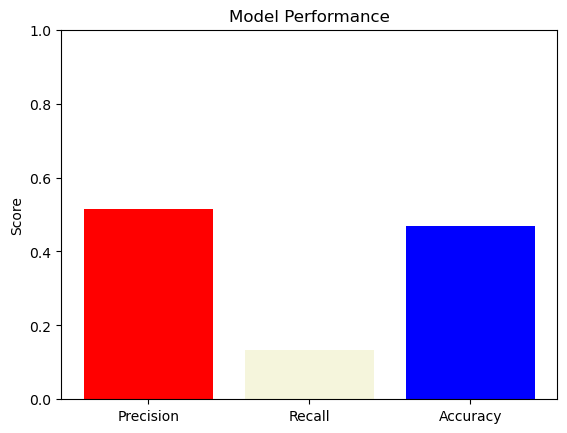

In [84]:
metrics = {"Precision": precision, "Recall": recall, "Accuracy": accuracy}
plt.bar(metrics.keys(), metrics.values(), color=["red", "beige", "blue"])
plt.title("Model Performance")
plt.ylim(0, 1)
plt.ylabel("Score")
plt.show()